## Train a rescvae for the handwritten digits simulation

In [1]:
# Copyright (C) 2018 Zhixian MA <zx@mazhixian.me>

In [2]:
import matplotlib
matplotlib.use('Agg')
%matplotlib inline
import matplotlib.pyplot as plt

In [3]:
import tensorflow as tf

/usr/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [4]:
from rescvae.rescvae import rescvae
from rescvae.utils import utils

In [5]:
from rescvae.configs import config_mnist
from rescvae.configs import config_train

### Load mnist data

In [6]:
# Step1 load MNITST data
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("MNIST_data", one_hot=True, validation_size=5000)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [7]:
cf = config_mnist
tr_cf = config_train

### Build the net and train

In [8]:
net = rescvae(cf)
net.cvae_build()
net.net_print()

(?, 14, 14, 8)
(?, 7, 7, 16)
(?, 14, 14, 8)
(?, 28, 28, 1)
Layer ID    Layer type    Layer shape
0 Input layer [None, 28, 28, 11]
1 Block_en_0 [None, 28, 28, 11]
2 Block_en_1 [None, 14, 14, 8]
3 En_flatten [None, 784]
4 En_mu [None, 128]
5 En_sigma [None, 128]
6 z [None, 128]
7 De_flatten [None, 784]
8 De_flatten_to_conv [None, 7, 7, 16]
9 Block_de_0 [None, 14, 14, 8]
10 Block_de_1 [None, 28, 28, 1]
11 Output layer [None, 28, 28, 1]
12 Flatten [None, 28, 28, 1]


In [9]:
# train the net
net.cvae_train_mnist(mnist=mnist, train_configs=tr_cf)

[2018-11-27: 21:03:46]: Epochs    Trn_loss_recon    Val_loss_recon    Trn_loss_latent    Val_loss_latent
[2018-11-27: 21:04:04]:      0         179.77888         159.67807           14.03365            5.72141
[2018-11-27: 21:04:20]:      1         148.00918         141.92128            3.34084            2.86715
[2018-11-27: 21:04:37]:      2         136.28592         130.87835            1.81385            1.43260
[2018-11-27: 21:04:53]:      3         127.01765         122.70629            1.10188            0.73859
[2018-11-27: 21:05:09]:      4         118.81099         114.61035            0.67470            0.40714
[2018-11-27: 21:05:25]:      5         111.00614         106.98079            0.48631            0.35588
[2018-11-27: 21:05:41]:      6         104.22800         100.12917            0.47662            0.41641
[2018-11-27: 21:05:58]:      7          97.90905          93.50042            0.51720            0.46186
[2018-11-27: 21:06:15]:      8          91.94878       

### Test the net

In [10]:
n_examples = 10
img_test, label_test = mnist.test.next_batch(n_examples)
label_test_input = utils.condition_reshape(
    label=label_test, numclass=10, imgshape=(28,28))

In [11]:
img_est = net.sess.run(
    net.output_flatten_de, 
    feed_dict={net.inputs: img_test.reshape(-1,cf.rs,cf.rs,1), 
               net.outputs: img_test.reshape(-1,cf.rs,cf.rs,1),
               net.conditions: label_test,
               net.conditions_input: label_test_input,
               net.is_training: False,
               net.keep_prob:1.0
               })

/home/mzx/.local/lib/python3.6/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


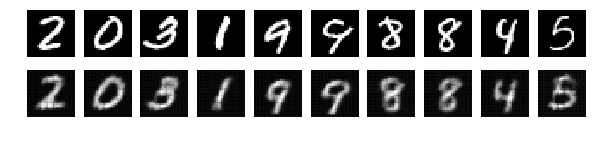

In [12]:
import numpy as np
fig, axs = plt.subplots(2, n_examples, figsize=(n_examples, 2))
for example_i in range(n_examples):
    # original
    axs[0][example_i].imshow(np.reshape(img_test[example_i, :], (28, 28)), cmap='gray')
    axs[0][example_i].axis('off')
    # reconstructed
    axs[1][example_i].imshow(np.reshape(img_est[example_i, :], (28, 28)), cmap='gray')
    axs[1][example_i].axis('off')

fig.show()
plt.draw()

### Save the net

In [13]:
import os
foldname = "./rescvae_mnist"
name = "rescvae.pkl"
netname = "model_rescvae.ckpt"
namepath = os.path.join(foldname, name)
netpath = os.path.join(foldname, netname)
savedict = {'netpath': netpath}
if os.path.exists(foldname):
    os.system("rm -r %s" % (foldname))
os.mkdir(foldname)
utils.save_net(sess=net.sess,
               namepath=namepath,
               netpath=netpath,
               savedict=savedict)